<a href="https://colab.research.google.com/github/Srilakshmi-Kande/AI-DeepVision/blob/KandeSrilakshmi/trained_model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, cv2
import numpy as np
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from tqdm.auto import tqdm

# Paths you provided
TRAIN_IMG_DIR = "/content/drive/MyDrive/crowd_project/Train/images"
TRAIN_GT_DIR  = "/content/drive/MyDrive/crowd_project/Train/ground_truth"

TEST_IMG_DIR  = "/content/drive/MyDrive/crowd_project/Test/images"
TEST_GT_DIR   = "/content/drive/MyDrive/crowd_project/Test/ground_truth"

In [3]:
PROCESSED_TRAIN_IMG = "/content/drive/MyDrive/crowd_project/processed_train_images"
PROCESSED_TRAIN_DEN = "/content/drive/MyDrive/crowd_project/processed_train_density"

PROCESSED_TEST_IMG = "/content/drive/MyDrive/crowd_project/processed_test_images"
PROCESSED_TEST_DEN = "/content/drive/MyDrive/crowd_project/processed_test_density"

os.makedirs(PROCESSED_TRAIN_IMG, exist_ok=True)
os.makedirs(PROCESSED_TRAIN_DEN, exist_ok=True)
os.makedirs(PROCESSED_TEST_IMG, exist_ok=True)
os.makedirs(PROCESSED_TEST_DEN, exist_ok=True)

In [4]:
def process_partA_data(img_dir, gt_dir, out_img_dir, out_den_dir):
    file_list = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])

    for file in tqdm(file_list):
        img_path = os.path.join(img_dir, file)
        gt_path  = os.path.join(gt_dir,  "GT_" + file.replace(".jpg",".mat"))

        # Load and resize image to 512x512
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512,512))
        cv2.imwrite(os.path.join(out_img_dir, file), img)

        # Load GT annotation points
        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]  # shape: (N, 2)

        # Create density map in 64x64 resolution
        h, w = 64, 64
        density = np.zeros((h, w), dtype=np.float32)

        # place 1 for each head point (downsampled location)
        for x, y in points:
            xs = int(x * w / img.shape[1])
            ys = int(y * h / img.shape[0])
            if 0 <= xs < w and 0 <= ys < h:
                density[ys, xs] += 1

        # Apply Gaussian Blur → smooth distribution
        density = gaussian_filter(density, sigma=1.5)

        # Save density map
        np.save(os.path.join(out_den_dir, file.replace(".jpg",".npy")), density)

In [ ]:
process_partA_data(TRAIN_IMG_DIR, TRAIN_GT_DIR,
                   PROCESSED_TRAIN_IMG, PROCESSED_TRAIN_DEN)

process_partA_data(TEST_IMG_DIR, TEST_GT_DIR,
                   PROCESSED_TEST_IMG, PROCESSED_TEST_DEN)

print("\nProcessing Completed Successfully!")

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]


Processing Completed Successfully!


In [5]:
sample = np.load(os.path.join(PROCESSED_TRAIN_DEN, os.listdir(PROCESSED_TRAIN_DEN)[0]))
print("Sample GT Count =", sample.sum())
print("Density shape =", sample.shape)

Sample GT Count = 587.0
Density shape = (64, 64)


In [6]:
import os, cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as T
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

TRAIN_IMG = "/content/drive/MyDrive/crowd_project/processed_train_images"
TRAIN_DEN = "/content/drive/MyDrive/crowd_project/processed_train_density"

TEST_IMG  = "/content/drive/MyDrive/crowd_project/processed_test_images"
TEST_DEN  = "/content/drive/MyDrive/crowd_project/processed_test_density"

Using: cuda


In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, files):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]

        img = cv2.imread(os.path.join(self.img_dir, name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(img)

        den = np.load(os.path.join(self.den_dir, name.replace(".jpg",".npy")))
        den = torch.tensor(den, dtype=torch.float32).unsqueeze(0)
        return img, den


In [8]:
files = sorted([f for f in os.listdir(TRAIN_IMG) if f.endswith('.jpg')])
train_f, val_f = train_test_split(files, test_size=0.2, random_state=42)

train_loader = DataLoader(CrowdDataset(TRAIN_IMG, TRAIN_DEN, train_f),
                          batch_size=4, shuffle=True)
val_loader   = DataLoader(CrowdDataset(TRAIN_IMG, TRAIN_DEN, val_f),
                          batch_size=4, shuffle=False)

print("Train:", len(train_f), " | Val:", len(val_f))

Train: 240  | Val: 60


In [9]:
cfg = {'frontend':[64,64,'M',128,128,'M',256,256,256,'M',512,512,512],
       'backend':[512,512,512,256,128,64]}

def make_layers(cfg_list, in_channels=3, dilation=False):
    layers=[]
    for v in cfg_list:
        if v=='M':
            layers.append(nn.MaxPool2d(2,2))
        else:
            d=2 if dilation else 1
            layers += [nn.Conv2d(in_channels, v, 3, padding=d, dilation=d),
                       nn.ReLU(inplace=True)]
            in_channels=v
    return nn.Sequential(*layers)

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.frontend = make_layers(cfg['frontend'],3)
        self.backend = make_layers(cfg['backend'],512,True)
        self.output = nn.Conv2d(64,1,1)
    def forward(self,x):
        x=self.frontend(x)
        x=self.backend(x)
        x=self.output(x)
        return x

model = CSRNet().to(device)

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.95)

In [ ]:
num_epochs = 100
best_loss = float('inf')

train_loss_list, val_loss_list = [], []
train_mae_list, val_mae_list = [], []

BEST_MODEL_PATH = "/content/drive/MyDrive/crowd_project/CSRNet_best.pth"

for epoch in range(num_epochs):
    model.train()
    t_loss = t_mae = 0

    for img, den in train_loader:
        img, den = img.to(device), den.to(device)

        pred = model(img)
        loss = criterion(pred, den)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_mae  += abs(pred.sum().item() - den.sum().item())

    t_loss /= len(train_loader)
    t_mae  /= len(train_loader)
    train_loss_list.append(t_loss)
    train_mae_list.append(t_mae)

    model.eval()
    v_loss = v_mae = 0
    with torch.no_grad():
        for img, den in val_loader:
            img, den = img.to(device), den.to(device)
            pred = model(img)

            v_loss += criterion(pred, den).item()
            v_mae  += abs(pred.sum().item() - den.sum().item())

    v_loss /= len(val_loader)
    v_mae  /= len(val_loader)
    val_loss_list.append(v_loss)
    val_mae_list.append(v_mae)

    print(f"Epoch: {epoch+1} | TL:{t_loss:.3f} VL:{v_loss:.3f} | TMAE:{t_mae:.2f} VMAE:{v_mae:.2f}")

    if v_loss < best_loss:
        best_loss = v_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("Best Model Saved")

    scheduler.step()

Epoch: 1 | TL:0.023 VL:0.021 | TMAE:449.46 VMAE:573.42
Best Model Saved
Epoch: 2 | TL:0.022 VL:0.020 | TMAE:411.33 VMAE:361.65
Best Model Saved
Epoch: 3 | TL:0.022 VL:0.020 | TMAE:411.72 VMAE:490.43
Best Model Saved
Epoch: 4 | TL:0.021 VL:0.019 | TMAE:406.40 VMAE:336.34
Best Model Saved
Epoch: 5 | TL:0.021 VL:0.020 | TMAE:488.77 VMAE:588.86
Epoch: 6 | TL:0.021 VL:0.018 | TMAE:489.44 VMAE:310.39
Best Model Saved
Epoch: 7 | TL:0.020 VL:0.018 | TMAE:417.82 VMAE:441.23
Epoch: 8 | TL:0.020 VL:0.017 | TMAE:531.95 VMAE:307.14
Best Model Saved
Epoch: 9 | TL:0.020 VL:0.018 | TMAE:456.99 VMAE:391.87
Epoch: 10 | TL:0.020 VL:0.017 | TMAE:464.58 VMAE:301.88
Epoch: 11 | TL:0.020 VL:0.019 | TMAE:515.74 VMAE:445.75
Epoch: 12 | TL:0.020 VL:0.017 | TMAE:509.27 VMAE:286.98
Best Model Saved
Epoch: 13 | TL:0.019 VL:0.017 | TMAE:448.10 VMAE:328.47
Best Model Saved
Epoch: 14 | TL:0.019 VL:0.017 | TMAE:399.32 VMAE:308.70
Best Model Saved
Epoch: 15 | TL:0.019 VL:0.016 | TMAE:391.35 VMAE:278.70
Best Model Saved

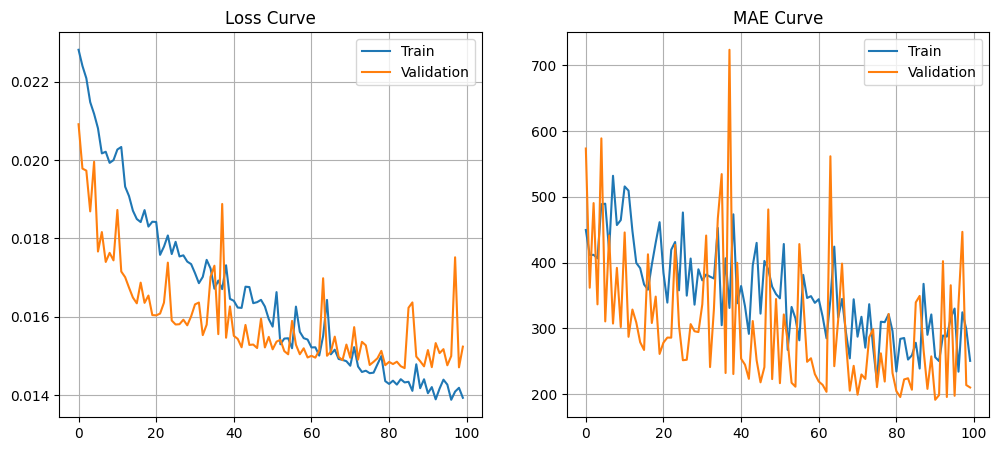

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list); plt.plot(val_loss_list)
plt.title("Loss Curve"); plt.legend(["Train","Validation"]); plt.grid()

plt.subplot(1,2,2)
plt.plot(train_mae_list); plt.plot(val_mae_list)
plt.title("MAE Curve"); plt.legend(["Train","Validation"]); plt.grid()

plt.show()

In [ ]:
from torchvision import models

model = CSRNet().to(device)

# Load pretrained VGG16-BN
vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

# Copy Conv layers only (ignore ReLU)
vgg_convs = [l for l in vgg.features if isinstance(l, nn.Conv2d)]
csr_convs = [l for l in model.frontend if isinstance(l, nn.Conv2d)]

for i in range(min(len(vgg_convs), len(csr_convs))):
    csr_convs[i].weight.data = vgg_convs[i].weight.data.clone()
    csr_convs[i].bias.data   = vgg_convs[i].bias.data.clone()

# IMPORTANT: Move frontend weights to GPU
model.frontend.to(device)

print(f"Loaded {i+1} pretrained conv layers & moved to {device}")

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:06<00:00, 86.5MB/s]


Loaded 10 pretrained conv layers & moved to cuda


In [ ]:
imgs, dens = next(iter(train_loader))
with torch.no_grad():
    pred = model(imgs.to(device))
print("GT Count:", dens.sum().item())
print("Pred Count:", pred.sum().item())

GT Count: 1256.0
Pred Count: 599.7951049804688


In [11]:
BEST_MODEL_A = "/content/drive/MyDrive/crowd_project/CSRNet_best.pth"

model = CSRNet().to(device)
model.load_state_dict(torch.load(BEST_MODEL_A, map_location=device))
model.eval()
print("Best Part-A model loaded!")

Best Part-A model loaded!


In [13]:
test_files = sorted(os.listdir(TEST_IMG))

test_loader = DataLoader(
    CrowdDataset(TEST_IMG, TEST_DEN, test_files),
    batch_size=1,
    shuffle=False
)
print("Test samples:", len(test_files))

Test samples: 182


In [14]:
abs_errs = []

with torch.no_grad():
    for img, den in test_loader:
        img, den = img.to(device), den.to(device)
        pred = model(img)
        abs_errs.append(abs(pred.sum().item() - den.sum().item()))

MAE  = np.mean(abs_errs)
MSE  = np.mean(np.square(abs_errs))
RMSE = np.sqrt(MSE)

print(" Part-A Test Results")
print(f"MAE  : {MAE:.2f}")
print(f"MSE  : {MSE:.2f}")
print(f"RMSE : {RMSE:.2f}")

 Part-A Test Results
MAE  : 98.13
MSE  : 19226.94
RMSE : 138.66


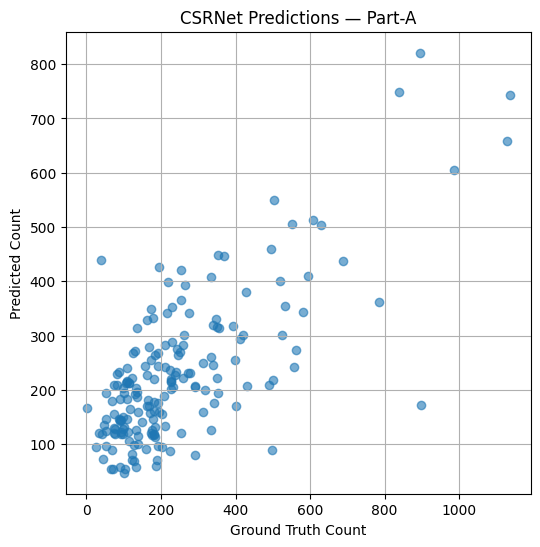

In [15]:
gt_list = []
pred_list = []

with torch.no_grad():
    for img, den in test_loader:
        img, den = img.to(device), den.to(device)
        pred = model(img)

        gt_list.append(den.sum().item())
        pred_list.append(pred.sum().item())

plt.figure(figsize=(6,6))
plt.scatter(gt_list, pred_list, alpha=0.6)
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("CSRNet Predictions — Part-A")
plt.grid(True)
plt.show()

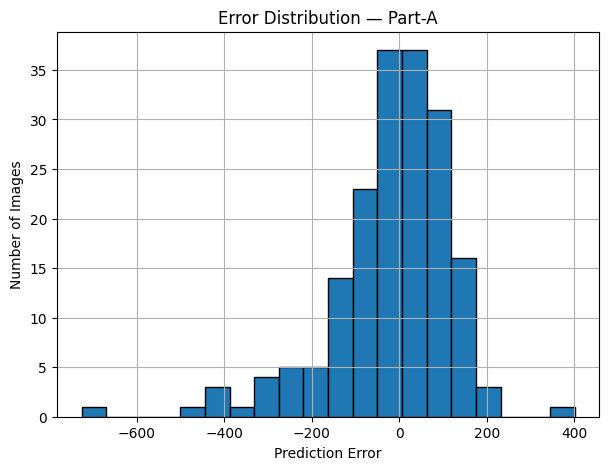

In [16]:
errors = np.array(pred_list) - np.array(gt_list)

plt.figure(figsize=(7,5))
plt.hist(errors, bins=20, edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Number of Images")
plt.title("Error Distribution — Part-A")
plt.grid(True)
plt.show()

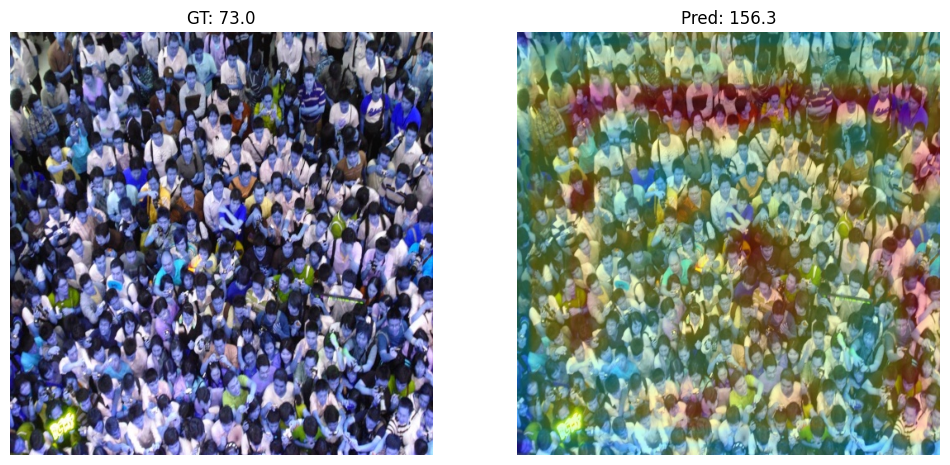

File: IMG_83.jpg
GT Count: 73.0 | Pred Count: 156.3


In [20]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

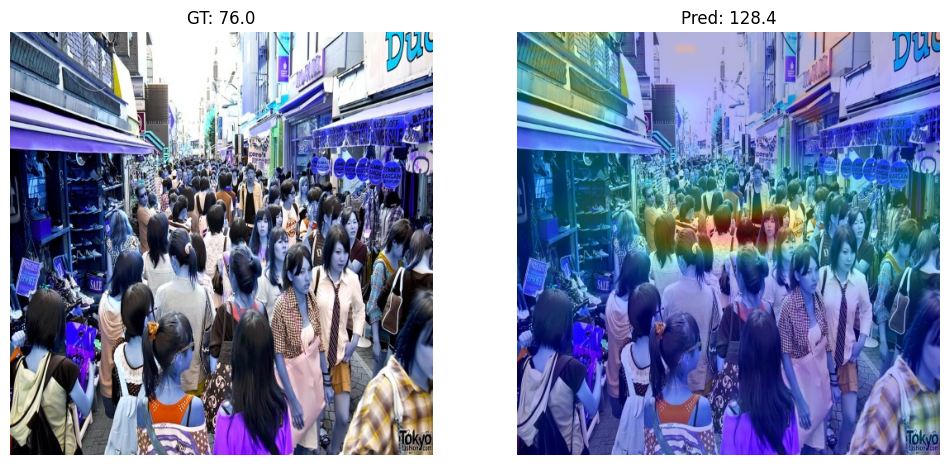

File: IMG_43.jpg
GT Count: 76.0 | Pred Count: 128.4


In [21]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

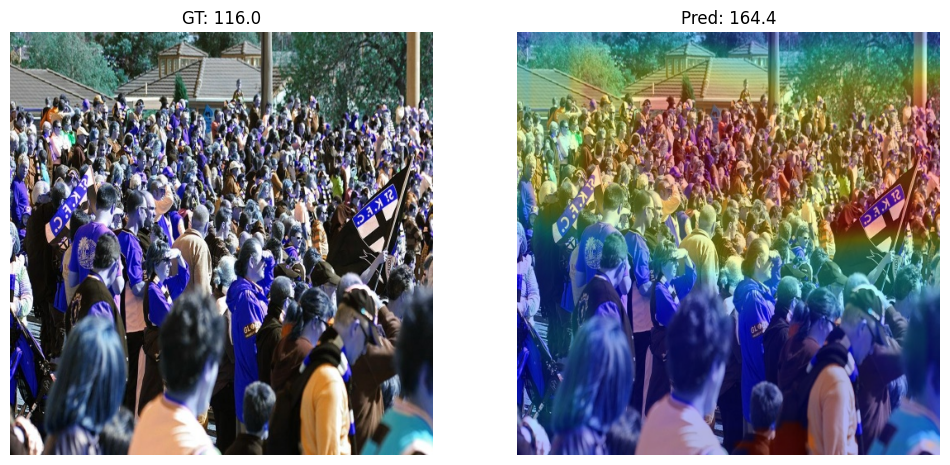

File: IMG_78.jpg
GT Count: 116.0 | Pred Count: 164.4


In [22]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

In [23]:
for param in model.frontend.parameters():
    param.requires_grad = False

print("Frontend frozen — Fine-tuning backend only!")

Frontend frozen — Fine-tuning backend only!


In [24]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,   # HIGHER than before: more correction learning
    weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [25]:
num_epochs = 30
best_loss = float('inf')

train_loss_list, val_loss_list = [], []
train_mae_list, val_mae_list = [], []

BEST_MODEL_PATH = "/content/drive/MyDrive/crowd_project/CSRNet_best.pth"

for epoch in range(1,num_epochs+1):
    model.train()
    t_loss = t_mae = 0

    for img, den in train_loader:
        img, den = img.to(device), den.to(device)

        pred = model(img)
        loss = criterion(pred, den)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item()
        t_mae  += abs(pred.sum().item() - den.sum().item())

    t_loss /= len(train_loader)
    t_mae  /= len(train_loader)
    train_loss_list.append(t_loss)
    train_mae_list.append(t_mae)

    model.eval()
    v_loss = v_mae = 0
    with torch.no_grad():
        for img, den in val_loader:
            img, den = img.to(device), den.to(device)
            pred = model(img)

            v_loss += criterion(pred, den).item()
            v_mae  += abs(pred.sum().item() - den.sum().item())

    v_loss /= len(val_loader)
    v_mae  /= len(val_loader)
    val_loss_list.append(v_loss)
    val_mae_list.append(v_mae)

    print(f"Epoch: {epoch+1} | TL:{t_loss:.3f} VL:{v_loss:.3f} | TMAE:{t_mae:.2f} VMAE:{v_mae:.2f}")

    if v_loss < best_loss:
        best_loss = v_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print("Best Model Saved")

    scheduler.step()

Epoch: 2 | TL:0.015 VL:0.015 | TMAE:379.48 VMAE:207.13
Best Model Saved
Epoch: 3 | TL:0.014 VL:0.016 | TMAE:271.24 VMAE:250.66
Epoch: 4 | TL:0.014 VL:0.017 | TMAE:326.31 VMAE:487.89
Epoch: 5 | TL:0.015 VL:0.015 | TMAE:327.69 VMAE:226.14
Best Model Saved
Epoch: 6 | TL:0.015 VL:0.016 | TMAE:301.54 VMAE:321.93
Epoch: 7 | TL:0.015 VL:0.015 | TMAE:313.94 VMAE:213.82
Best Model Saved
Epoch: 8 | TL:0.015 VL:0.016 | TMAE:303.45 VMAE:248.91
Epoch: 9 | TL:0.015 VL:0.017 | TMAE:287.77 VMAE:353.70
Epoch: 10 | TL:0.014 VL:0.015 | TMAE:280.10 VMAE:241.63
Epoch: 11 | TL:0.015 VL:0.015 | TMAE:319.44 VMAE:228.74
Epoch: 12 | TL:0.015 VL:0.015 | TMAE:251.96 VMAE:251.87
Epoch: 13 | TL:0.014 VL:0.015 | TMAE:235.54 VMAE:210.25
Epoch: 14 | TL:0.014 VL:0.015 | TMAE:313.65 VMAE:217.91
Epoch: 15 | TL:0.014 VL:0.022 | TMAE:262.46 VMAE:628.36
Epoch: 16 | TL:0.014 VL:0.015 | TMAE:282.18 VMAE:197.71
Epoch: 17 | TL:0.014 VL:0.015 | TMAE:214.34 VMAE:249.71
Epoch: 18 | TL:0.014 VL:0.015 | TMAE:280.29 VMAE:253.47
Epoch

In [27]:
for i in range(5):
    name = test_files[i]
    img = cv2.imread(os.path.join(TEST_IMG, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    den = np.load(os.path.join(TEST_DEN, name.replace(".jpg",".npy")))
    gt = den.sum()

    with torch.no_grad():
        pr = model(transform(img).unsqueeze(0).to(device)).sum().item()

    print(f"{name} → GT:{gt:.1f} | Pred:{pr:.1f}")

IMG_1.jpg → GT:88.0 | Pred:303.0
IMG_10.jpg → GT:226.0 | Pred:303.7
IMG_100.jpg → GT:212.0 | Pred:325.7
IMG_101.jpg → GT:137.0 | Pred:391.8
IMG_102.jpg → GT:223.0 | Pred:332.6


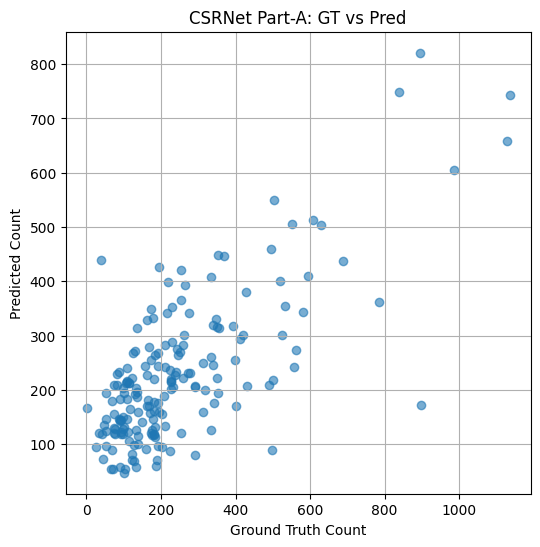

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(gt_list, pred_list, alpha=0.6)
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("CSRNet Part-A: GT vs Pred")
plt.grid(True)
#plt.savefig("scatter_PartA.png")
plt.show()

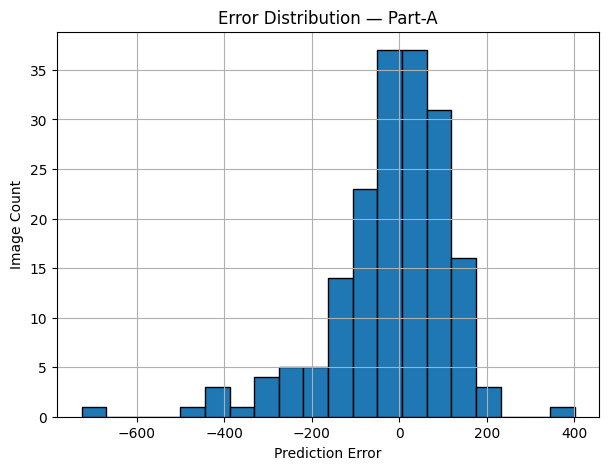

In [29]:
errors = np.array(pred_list) - np.array(gt_list)
plt.figure(figsize=(7,5))
plt.hist(errors, bins=20, edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Image Count")
plt.title("Error Distribution — Part-A")
plt.grid(True)
#plt.savefig("error_hist_PartA.png")
plt.show()

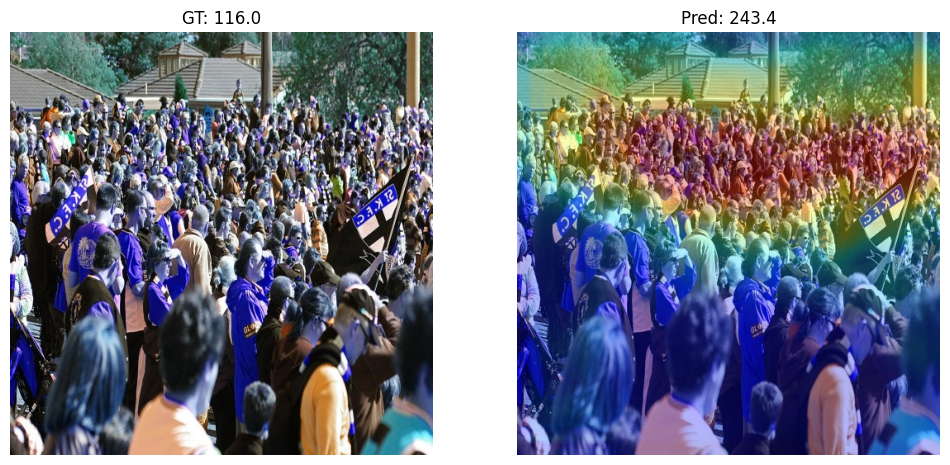

File: IMG_78.jpg
GT Count: 116.0 | Pred Count: 243.4


In [31]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

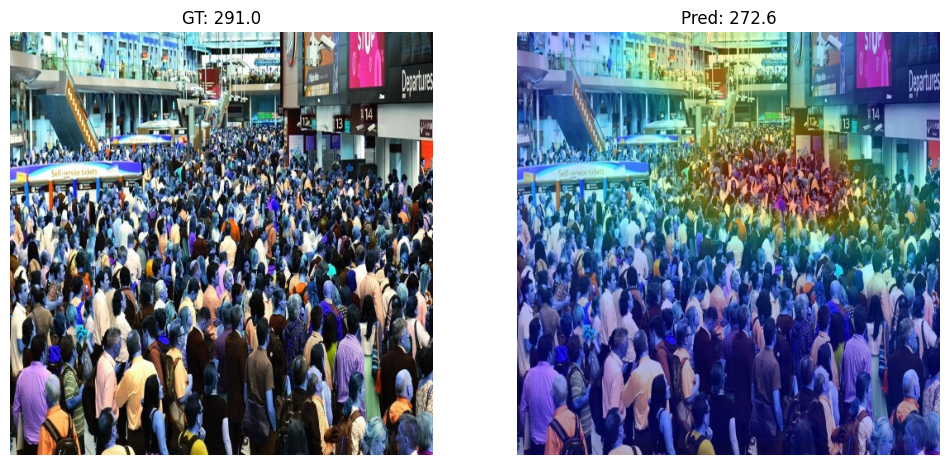

File: IMG_13.jpg
GT Count: 291.0 | Pred Count: 272.6


In [32]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

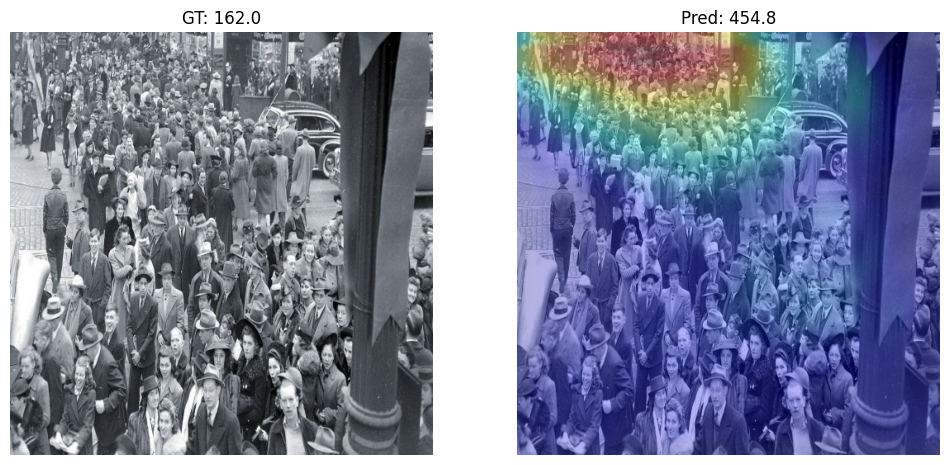

File: IMG_118.jpg
GT Count: 162.0 | Pred Count: 454.8


In [33]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

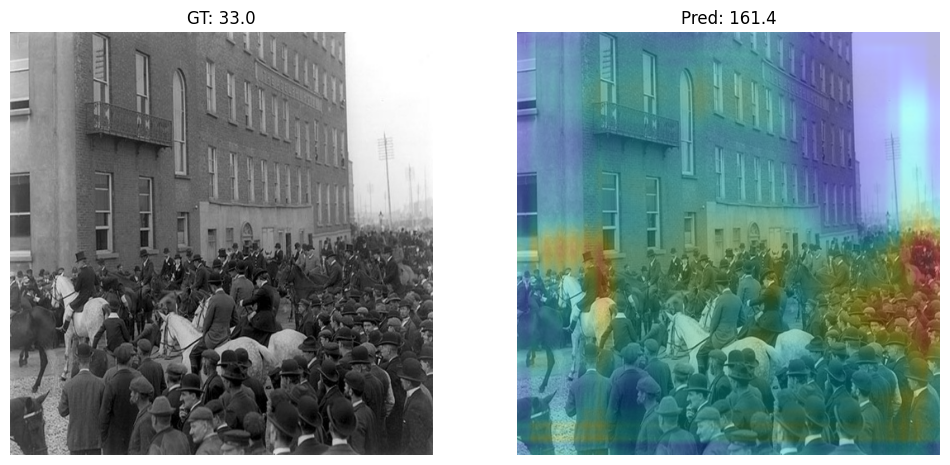

File: IMG_45.jpg
GT Count: 33.0 | Pred Count: 161.4


In [34]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")

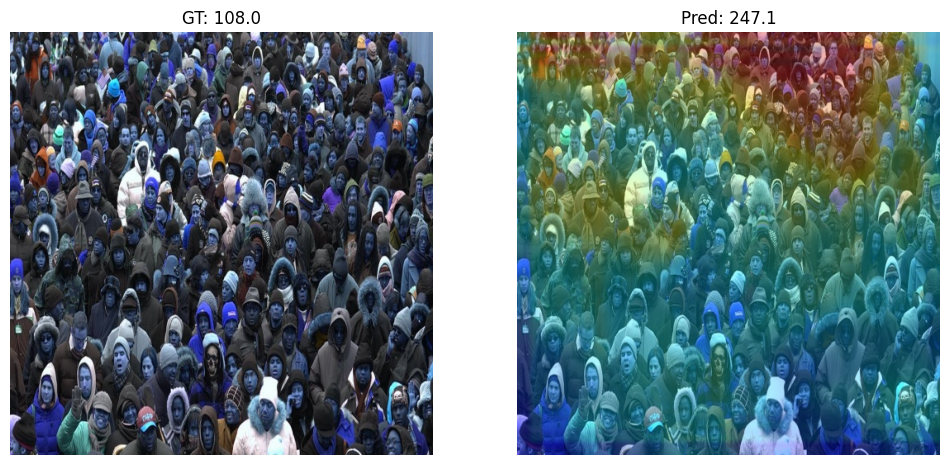

File: IMG_31.jpg
GT Count: 108.0 | Pred Count: 247.1


In [35]:
import random

name = random.choice(test_files)

img = cv2.imread(os.path.join(TEST_IMG, name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

den = np.load(os.path.join(TEST_DEN, name.replace(".jpg", ".npy")))
gt = den.sum()

# Run Prediction
with torch.no_grad():
    pred = model(transform(img).unsqueeze(0).to(device))
den_pred = pred.squeeze().cpu().numpy()
pr = den_pred.sum()

# Create heatmap at output resolution (64x64)
heat = cv2.applyColorMap((den_pred / den_pred.max() * 255).astype(np.uint8),
                         cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

# Resize heatmap to original image size (512x512)
heat_resized = cv2.resize(heat, (img.shape[1], img.shape[0]))

# Overlay
overlay = cv2.addWeighted(img, 0.7, heat_resized, 0.3, 0)

# Plotting
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"GT: {gt:.1f}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title(f"Pred: {pr:.1f}")
plt.axis("off")

plt.show()

print("File:", name)
print(f"GT Count: {gt:.1f} | Pred Count: {pr:.1f}")